In [2]:
import easyocr
import cv2
import matplotlib.pyplot as plt


import requests
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import uuid
import hashlib

import os
import matplotlib.pyplot as plt


import torch
from PIL import Image
from rembg import new_session, remove
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
import torch

/root/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
FLUX_SERVER_ENDPOINT = 'http://192.165.134.27:22186/flux-generate-image'
FLUX_SERVER_ENDPOINT = 'http://127.0.0.1:11234/flux-generate-image'
FLUX_TIMEOUT = 300
save_dir = 'data_prize_words/generated'
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
def get_hash_from_uuid(hash_val: str | None = None, hash_len: int = 5) -> str:
    # Generate a UUID4 and convert it to a string
    if not hash_val:
        hash_val = str(uuid.uuid4())

    # Hash the UUID string using SHA-256
    hash_object = hashlib.sha256(hash_val.encode())
    hex_dig = hash_object.hexdigest()
    return hex_dig[:hash_len]

In [14]:
def flux_get_image_from_prompt(
    prompt: str,
    save_path: str,
    resolution: tuple | None = None,
    num_inference_steps: int = 28,
    guidance_scale: float = 3.5,
    seed: int = 24,
) -> str:
    resolution = resolution if resolution else (1024, 1024)
    width, height = resolution
    data = {
        'prompt': prompt,
        'width': width,
        'height': height,
        'seed': seed,
        'num_inference_steps': num_inference_steps,
        'guidance_scale': guidance_scale,
    }

    response = requests.post(
        FLUX_SERVER_ENDPOINT,
        data=data,
        timeout=FLUX_TIMEOUT,
    )

    if response.status_code == 200:
        with Path(save_path).open('wb') as output_file:
            output_file.write(response.content)

        return save_path
    raise ValueError(f'Bad response from FLUX API. Status code: {response.status_code}')

In [4]:
from diffusers import FluxPipeline
lora_path = "/root/lowlettersfluxv3-000073.safetensors"
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16).to("cuda")
pipe.load_lora_weights(lora_path, adapter_name="letters")
pipe.set_adapters("letters", 1.0)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 15.43it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [5]:
def generate_image_with_flux_lora(prompt, save_path):
    out = pipe(
        prompt=prompt,
        guidance_scale=3.5,
        height=1024,
        width=1024,
        num_inference_steps=50,
    ).images[0]
    out.save(save_path)
    return save_path

In [6]:
def generate_single_image(prompt):
    unique_save_path = Path(save_dir) / f"{get_hash_from_uuid(hash_val=prompt)}.png"
    generated_image_path = generate_image_with_flux_lora(prompt=prompt, save_path=unique_save_path)
    return generated_image_path

## Segmentation

In [7]:
def remove_background_from_symbol(src: str, dest: str) -> None:
    torch.set_float32_matmul_precision('high')

    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    model: torch.nn.Module = AutoModelForImageSegmentation.from_pretrained(
        'briaai/RMBG-2.0', trust_remote_code=True
    )

    model.to(device)
    model.eval()

    to_pillow: transforms.ToPILImage = transforms.ToPILImage()

    transform_image: transforms.Compose = transforms.Compose(
        [
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),
        ]
    )

    img = Image.open(src)
    input_img: torch.Tensor = transform_image(img).unsqueeze(0).to(device)

    with torch.no_grad():
        mask: torch.Tensor = model(input_img)[-1].sigmoid()[0].squeeze().cpu()

    img.putalpha(to_pillow(mask).resize(img.size))
    img.save(dest)

## Word detection

In [27]:
def detect_multi_words(image_path: str, new_width=500, new_height=500):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    reader = easyocr.Reader(['en'])
    results = reader.readtext(gray, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    processed_results = []
    for bbox, text, prob in results:
        print(text)
        words = text.split()
        if len(words) > 1:
            x_min = min([point[0] for point in bbox])
            x_max = max([point[0] for point in bbox])
            y_min = min([point[1] for point in bbox])
            y_max = max([point[1] for point in bbox])
            
            width_per_word = (x_max - x_min) // len(words)
            
            for i, word in enumerate(words):
                new_bbox = [[x_min + i * width_per_word, y_min], 
                            [x_min + (i + 1) * width_per_word, y_min],
                            [x_min + (i + 1) * width_per_word, y_max], 
                            [x_min + i * width_per_word, y_max]]
                processed_results.append((word, new_bbox, prob / len(words)))
        else:
            processed_results.append((text, bbox, prob))
    
    return processed_results, image

In [32]:
import cv2
import numpy as np
import easyocr

def detect_letters_via_contours(image_path: str,
                                resize_dim=(600, 600),
                                min_area=500):
    # 1. Load & resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, resize_dim, interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Threshold to separate glyphs (dark) from background (light)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # 3. Clean up small holes/bridges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4. Find external contours = one per letter
    contours, _ = cv2.findContours(clean,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # 5. Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False)

    results = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < min_area:
            continue  # skip noise

        # 6. Crop the letter and OCR it
        crop = gray[y:y+h, x:x+w]
        ocr = reader.readtext(
            crop,
            allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ',
            detail=1,
            paragraph=False
        )
        if not ocr:
            continue

        # 7. Extract the recognized character
        letter = ocr[0][1]
        bbox = [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]
        results.append((letter, bbox))

    return results, img

# Example usage:
letters, annotated = detect_letters_via_contours('/root/flux/notebooks/data_prize_words/generated/d1053.png')
for ch, box in letters:
    print(f"Found letter {ch} at {box}")


Using CPU. Note: This module is much faster with a GPU.


Found letter Q at [(321, 336), (519, 336), (519, 573), (321, 573)]
Found letter K at [(64, 331), (267, 331), (267, 558), (64, 558)]
Found letter A at [(61, 25), (276, 25), (276, 279), (61, 279)]


In [35]:
import cv2
import numpy as np

# Load and preprocess exactly as in your function
img = cv2.imread('/root/flux/notebooks/data_prize_words/generated/d1053.png')
img = cv2.resize(img, (600, 600), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [8]:
import cv2
import numpy as np
from typing import List, Tuple

def detect_four_letter_boxes(
    image_path: str,
    resize_dim: Tuple[int,int]=(600,600),
    thresh_val: int=200,
    min_area: int=1000,
    margin: int=10
) -> List[Tuple[int,int,int,int]]:
    """
    Detect four letter regions in a 2x2 grid image, 
    and expand each bounding box by `margin` pixels.
    
    Returns:
        List of 4 boxes as (x1, y1, x2, y2) in reading order.
    """
    # 1. Load & resize
    img = cv2.imread(image_path)
    # img = cv2.resize(img, resize_dim, interpolation=cv2.INTER_LINEAR)
    img_w, img_h = img.shape[:2]
    
    # 2. Grayscale & threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)
    
    # 3. Morphology close to fill small holes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 4. Find external contours
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 5. Keep the four largest by area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contours = [c for c in contours if cv2.contourArea(c) >= min_area][:4]
    
    # 6. Compute their raw bounding boxes
    raw_boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        raw_boxes.append((x, y, x+w, y+h))
    
    # 7. Sort boxes in reading order (top row left→right, then bottom row)
    raw_boxes = sorted(raw_boxes, key=lambda b: b[1])
    top_row = sorted(raw_boxes[:2], key=lambda b: b[0])
    bot_row = sorted(raw_boxes[2:], key=lambda b: b[0])
    ordered = top_row + bot_row
    
    # 8. Expand each box by margin, clamped to image size
    padded_boxes = []
    for x1, y1, x2, y2 in ordered:
        ex1 = max(x1 - margin, 0)
        ey1 = max(y1 - margin, 0)
        ex2 = min(x2 + margin, img_w)
        ey2 = min(y2 + margin, img_h)
        padded_boxes.append((ex1, ey1, ex2, ey2))
    
    return padded_boxes


Detected letter boxes:
 Letter 1: (65,56) → (785,713)
 Letter 2: (836,64) → (1340,715)
 Letter 3: (78,818) → (764,1472)
 Letter 4: (776,824) → (1469,1472)


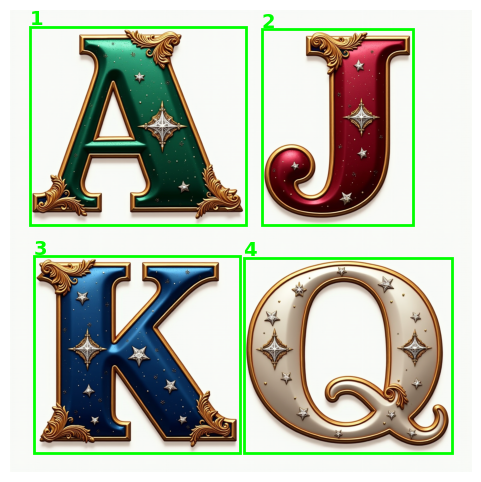

In [9]:
img_path = "/root/multiple_prize_words.png"
boxes = detect_four_letter_boxes(img_path)
print("Detected letter boxes:")
for i, (x1,y1,x2,y2) in enumerate(boxes, 1):
    print(f" Letter {i}: ({x1},{y1}) → ({x2},{y2})")


import cv2
import matplotlib.pyplot as plt

# Read and resize exactly as above
img = cv2.imread(img_path)
# img = cv2.resize(img, (600, 600), interpolation=cv2.INTER_LINEAR)

# Convert BGR to RGB for plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_rgb)
ax.axis('off')

# Draw rectangles
for idx, (x1, y1, x2, y2) in enumerate(boxes, start=1):
    width, height = x2 - x1, y2 - y1
    rect = plt.Rectangle(
        (x1, y1),
        width,
        height,
        fill=False,
        linewidth=2,
        edgecolor='lime'
    )
    ax.add_patch(rect)
    ax.text(
        x1,
        y1 - 5,
        str(idx),
        fontsize=14,
        color='lime',
        weight='bold'
    )

plt.show()

In [52]:
import os
import cv2
from pathlib import Path
from typing import List, Tuple

def save_cropped_letters_from_boxes(
    image_path: str,
    boxes: List[Tuple[int,int,int,int]],
    output_folder: str = "cropped_letters",
    resize_dim: Tuple[int,int] = (600, 600)
) -> List[str]:
    """
    Given an image and a list of bounding boxes (x1,y1,x2,y2),
    crops each region from the resized image and saves them as
    1.png, 2.png, … under `output_folder`. Returns list of file paths.
    """
    # 1. Load and resize just as in your detection function
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Unable to load image at {image_path}")
    img = cv2.resize(img, resize_dim, interpolation=cv2.INTER_LINEAR)

    # 2. Prepare output directory
    out_dir = Path(output_folder)
    out_dir.mkdir(parents=True, exist_ok=True)

    saved_paths = []
    # 3. Crop and save each box
    for idx, (x1, y1, x2, y2) in enumerate(boxes, start=1):
        # ensure ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # clamp coords to image
        x1, y1 = max(0, x1), max(0, y1)
        x2 = min(resize_dim[0], x2)
        y2 = min(resize_dim[1], y2)

        crop = img[y1:y2, x1:x2]
        save_path = out_dir / f"{idx}.png"
        cv2.imwrite(str(save_path), crop)
        saved_paths.append(str(save_path))

    return saved_paths

In [53]:
img_path = "/root/flux/notebooks/data_prize_words/generated/d1053.png"
boxes = detect_four_letter_boxes(img_path, margin=10)
paths = save_cropped_letters_from_boxes(img_path, boxes, output_folder="letters_out")


Saved letter crops: ['letters_out/1.png', 'letters_out/2.png', 'letters_out/3.png', 'letters_out/4.png']


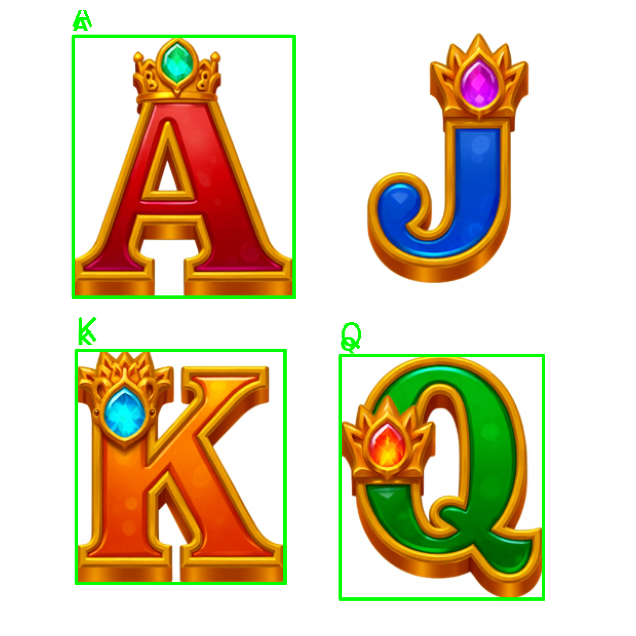

In [34]:
import matplotlib.pyplot as plt

# Convert BGR (OpenCV) to RGB for Matplotlib
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(annotated_rgb)
ax.axis('off')

# add boxes and labels
for letter, bbox in letters:
    x1, y1 = bbox[0]
    x3, y3 = bbox[2]
    width, height = x3 - x1, y3 - y1
    # draw rectangle
    rect = plt.Rectangle(
        (x1, y1), width, height,
        fill=False, linewidth=2, edgecolor='lime'
    )
    ax.add_patch(rect)
    # label
    ax.text(
        x1, y1 - 5, letter,
        fontsize=14, color='lime',
        weight='bold'
    )

plt.show()


In [ ]:
img_path = '/root/flux/notebooks/data_prize_words/generated/d1053.png'
res = detect_multi_words(img_path)

AJ
KQ


In [20]:
len(res)

2

In [9]:
def save_cropped_words(image, detected_words, output_folder="cropped_words"):

    # Create output folder if it doesn’t exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cropped_images = []

    # Iterate through detected words and crop them
    dir_to_save = Path(output_folder) / get_hash_from_uuid(hash_len=3)
    Path(dir_to_save).mkdir(parents=True, exist_ok=True)
    for i, (word, bbox, prob) in enumerate(detected_words):
        # Ensure correct bounding box extraction
        x_min = int(min(point[0] for point in bbox))
        x_max = int(max(point[0] for point in bbox))
        y_min = int(min(point[1] for point in bbox))
        y_max = int(max(point[1] for point in bbox))

        # Ensure coordinates are within the image bounds
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(image.shape[1], x_max)
        y_max = min(image.shape[0], y_max)

        # Prevent invalid cropping
        if x_max > x_min and y_max > y_min:
            cropped = image[y_min:y_max, x_min:x_max]            
            filename = f"{dir_to_save}/{word}_{i}.png"
            cv2.imwrite(filename, cropped)

            # Store cropped image for visualization
            cropped_images.append((word, cropped, filename))
            
            remove_background_from_symbol(filename, filename)

    return str(dir_to_save)

In [50]:
import os
import cv2
from pathlib import Path
from typing import List, Tuple

def split_image_into_quadrants(
    image_path: str,
    output_folder: str = "quadrants"
) -> List[str]:
    """
    Splits an image into its four quadrants (top-left, top-right, bottom-left, bottom-right)
    based on the center of the image, saves them as 1.png, 2.png, 3.png, 4.png,
    and returns the list of saved file paths.
    """
    # 1. Load
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {image_path}")
    h, w = img.shape[:2]

    # 2. Compute center
    cx, cy = w // 2, h // 2

    # 3. Define the four regions
    regions: List[Tuple[int,int,int,int]] = [
        (0,   0,  cx, cy),  # 1: top-left
        (cx,  0,  w,  cy),  # 2: top-right
        (0,   cy, cx, h ),  # 3: bottom-left
        (cx,  cy, w,  h )   # 4: bottom-right
    ]

    # 4. Prepare output directory
    out_dir = Path(output_folder)
    out_dir.mkdir(parents=True, exist_ok=True)

    # 5. Crop & save
    saved_paths = []
    for idx, (x0, y0, x1, y1) in enumerate(regions, start=1):
        crop = img[y0:y1, x0:x1]
        save_path = out_dir / f"{idx}.png"
        cv2.imwrite(str(save_path), crop)
        saved_paths.append(str(save_path))

    return saved_paths

In [51]:
img_path = "/root/flux/notebooks/data_prize_words/generated/e97f7.png"
saved = split_image_into_quadrants(img_path, output_folder="cropped_letters")
print("Saved quadrant images:", saved)

Saved quadrant images: ['cropped_letters/1.png', 'cropped_letters/2.png', 'cropped_letters/3.png', 'cropped_letters/4.png']


In [14]:
def generate_words(prompt):
    gen_params = {
        'num_inference_steps': 30, 
        'guidance_scale': 10.0,
        'seed': 2,
        'resolution': (1518, 1518)
    }
    image_path = generate_single_image(prompt=prompt)
    print(f'Generated image path: {image_path}')
    detected_words, image = detect_multi_words(image_path)
    saved_dir_path = save_cropped_words(image, detected_words)
    
    print(f"Saved to: {saved_dir_path}")    

### Anime

In [15]:
words_prompts = f"""lowletters, The image is made in a cyberpand style with a bright neon texture. It features four large letters each surrounded by a wide golden border. The inside of the letters is painted in rich colors, and the thin veins and cracks on the surface resemble the texture of wood, giving them a man-made and expressive appearance.A vertical composition of five text words arranged from top to bottom. The first word is "MAJOR", the second is "MINOR", the third is "MINI". The color of the text is different, the first is gold, the second is red, the third is purple, the fourth is blue, the fifth is turquoise. The text is written in large capital letters, clearly centered. White background."""

generate_words(prompt=words_prompts)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['arranged from top to bottom. the first word is " major ", the second is " minor ", the third is " mini ". the color of the text is different, the first is gold, the second is red, the third is purple, the fourth is blue, the fifth is turquoise. the text is written in large capital letters, clearly centered. white background.']
100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


Generated image path: data_prize_words/generated/ccc99.png
Saved to: cropped_words/3be


In [16]:
words_prompts = f"""lowletters, Bright, elegant letters with regal motifs, each surrounded by a golden outline and complemented by decorative elements in the form of crowns or stylized flaming emblems. Each color, "A" red, "J" blue, "K" orange, "Q" green, is associated with precious stones, and the smooth glossy surfaces emphasize the luxurious and heroic character. Gold and bright inserts with stones give the letters a sense of royal splendor, as if they were parts of a ceremonial decoration or symbols from a fabulous fantasy world. The letter "A" is located in the upper left corner. The letter "K" is located in the lower left corner. The letter "J" is located in the upper right corner. The letter "Q" is located in the lower right corner. White background."""

generate_words(prompt=words_prompts)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and heroic character. gold and bright inserts with stones give the letters a sense of royal splendor, as if they were parts of a ceremonial decoration or symbols from a fabulous fantasy world. the letter " a " is located in the upper left corner. the letter " k " is located in the lower left corner. the letter " j " is located in the upper right corner. the letter " q " is located in the lower right corner. white background.']
100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Generated image path: data_prize_words/generated/d1053.png
Saved to: cropped_words/fcc


In [17]:
words_prompts = f"""lowletters, Three-dimensional letters with smooth curves, made of polished metal, which reflects the glare and creates a modern, almost futuristic look. Inside or on the surface of each letter there are contrasting inserts of saturated shades, "A" purple, "J" orange, "K" burgundy, "Q" red, resembling translucent inserts of colored glass or precious stones. The overall impression combines high-tech and fantasy aesthetics, giving the letters a dynamic, energetic look with touches of refined luxury. The letter "A" is located in the upper left corner. The letter "K" is located in the lower left corner. The letter "J" is located in the upper right corner. The letter "Q" is located in the lower right corner. White background."""

generate_words(prompt=words_prompts)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['precious stones. the overall impression combines high - tech and fantasy aesthetics, giving the letters a dynamic, energetic look with touches of refined luxury. the letter " a " is located in the upper left corner. the letter " k " is located in the lower left corner. the letter " j " is located in the upper right corner. the letter " q " is located in the lower right corner. white background.']
100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


Generated image path: data_prize_words/generated/e97f7.png
Saved to: cropped_words/a16


In [1]:
# Validate letters

In [13]:
words_prompts = f"""lowletters, Bright three-dimensional letters, each of which resembles a translucent crystal of a certain color scheme, "A" orange, "J" ice blue, "K" pink, "Q" green, reflecting the play of light and emphasizing the texture of frozen fragments or hidden sparks inside. The style can be described as a combination of modern 3D design and fantasy game aesthetics, where each letter looks like a fantastic element carved from a precious mineral with shimmering patterns resembling intertwining frosty patterns. The letter "A" is located in the upper left corner. The letter "K" is located in the lower left corner. The letter "J" is located in the upper right corner. The letter "Q" is located in the lower right corner. White background. """

generate_words(prompt=words_prompts)

Token indices sequence length is longer than the specified maximum sequence length for this model (161 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['fantasy game aesthetics, where each letter looks like a fantastic element carved from a precious mineral with shimmering patterns resembling intertwining frosty patterns. the letter " a " is located in the upper left corner. the letter " k " is located in the lower left corner. the letter " j " is located in the upper right corner. the letter " q " is located in the lower right corner. white background.']


100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


Generated image path: data_prize_words/generated/8fb9f.png


/root/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Saved to: cropped_words/13b


### Spanch Bob

In [24]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, SpongeBob-style font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.

The typography embodies the wacky, playful, and bubbly aesthetic of the SpongeBob SquarePants universe, inspired by oceanic themes, underwater adventures, and cartoonish fun. The font is bouncy, wobbly, and slightly irregular, with a hand-drawn, organic feel, making the letters look as if they are floating underwater.

The colors are bright, tropical, and lively, featuring sunny yellows, ocean blues, coral oranges, and sandy beiges, evoking the vibrant world of Bikini Bottom. Each word has a thick, bold outline and may include bubble-like textures, wavy distortions, or soft, squishy edges to enhance the underwater, fun-loving aesthetic.

The background remains fully white, ensuring that the typography pops vividly while maintaining a clean separation between words. No additional symbols or elements—just pure SpongeBob-style typography, where each word stands alone in a whimsical, cartoonish, and high-energy composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/13578.png
Saved to: cropped_words/3ff


### USA

In [25]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, USA-style font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.

The typography embodies the patriotic, powerful, and bold aesthetic of American culture, inspired by classic American sports lettering, national pride, and vintage USA signage. The font is strong, blocky, and all-caps, with a varsity, collegiate, or bold sans-serif style, reminiscent of American football jerseys, political banners, or iconic USA logos.

The colors are red, white, and blue, representing the American flag, with deep navy blues, bold crimson reds, and crisp whites. Each word is outlined individually with a thick, high-contrast stroke, giving it a clean, structured look. Subtle star patterns, stripes, or a slight 3D effect may enhance the design, evoking the pride and energy of American themes.

The background remains fully white, ensuring that the typography pops vividly while maintaining a strong, patriotic presence. No additional symbols or elements—just pure USA-inspired typography, where each word stands alone in a bold, high-energy, and pride-filled composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/33bfa.png
Saved to: cropped_words/1fa


### Egyptian

In [26]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, Egyptian-inspired font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.
The typography embodies the mystical, ancient, and regal aesthetic of Egyptian civilization, inspired by hieroglyphic inscriptions, pharaonic stone carvings, and golden tomb engravings. The font is ornate and angular, with bold, structured letterforms featuring subtle curves and embellishments reminiscent of ancient Egyptian scripts. Some characters may have hieroglyphic-like extensions, decoative serifs, or a slightly weathered texture, enhancing the historic and mystical appearance.
The colors are rich and opulent, featuring deep gold, warm sandstone beige, and lapis lazuli blue, evoking the luxury of the pharaohs, the golden treasures of Tutankhamun, and the sacred stones of ancient temples. Each word has a thick, bold outline with subtle engravings or a chiseled effect, making the letters appear as if they are carved into an ancient monument or painted on a temple wall.
The background remains fully white, ensuring that the typography pops vividly while maintaining a clean, regal presence. No additional symbols or elements—just pure Egyptian-style typography, where each word stands alone in a timeless, mystical, and historically inspired composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/e37c3.png
Saved to: cropped_words/72e


### Harry Potter

In [27]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, Harry Potter-inspired font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.
The typography embodies the mystical, gothic, and enchanted aesthetic of the Harry Potter universe, inspired by ancient spellbooks, wizarding school inscriptions, and magical artifacts. The font is ornate, slightly elongated, and gothic-styled, with sharp, lightning-like serifs, flowing curves, and an old-world, medieval charm. Some letters may have wand-like extensions, flickering edges, or a subtle distressed texture, enhancing the magical, spellbinding effect.
The colors are deep and mysterious, featuring golden enchantments, dark midnight blues, smoky grays, and rich burgundy hues, evoking the magical aura of Hogwarts, enchanted scrolls, and wizard robes. Each word is outlined individually with a glowing, mystical aura or a soft golden shimmer, adding a spell-casting presence. Subtle floating sparkles, swirling mist, or lightning-inspired accents may enhance the typography, giving it the feel of a legendary incantation.
The background remains fully white, ensuring that the typography pops vividly while maintaining a magical and mysterious elegance. No additional symbols or elements—just pure Harry Potter-style typography, where each word stands alone in a well-spaced, enchanted, and wizardly composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/19e6c.png
Saved to: cropped_words/96d


### Magic Forest

In [28]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, enchanted Magic Forest-inspired font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.
The typography embodies the mystical, ethereal, and whimsical aesthetic of an enchanted forest, inspired by ancient woodland myths, fairy tales, and magical nature realms. The font is organic and slightly twisted, with elegant flourishes, vine-like extensions, and curving, nature-inspired strokes. Some letters may have leafy tendrils, roots curling around the edges, or subtle glowing highlights, evoking the presence of deep forest magic.
The colors are earthy and luminous, featuring emerald greens, twilight purples, soft mossy browns, and shimmering moonlight silvers, capturing the dreamlike atmosphere of glowing fungi, enchanted trees, and mystical woodland spirits. Each word is outlined individually with a subtle glow, giving the effect of bioluminescent plants or magical fireflies softly illuminating the letters. Delicate misty swirls, scattered fairy dust, or faint rune-like engravings may enhance the typography, giving it a sense of otherworldly wonder and ancient magic.
The background remains fully white, ensuring that the typography pops vividly while maintaining a dreamy and enchanted presence. No additional symbols or elements—just pure Magic Forest-style typography, where each word stands alone in a well-spaced, mystical, and nature-inspired composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/9dafb.png
Saved to: cropped_words/742


### Retro Cars

In [29]:
words_prompts = f"""
A high-resolution typography design featuring the words ‘MINI’, ‘MINOR’, and ‘MAJOR’ in a bold, retro cars-inspired font, each word placed separately with clear empty space around it. The words are not touching or overlapping, ensuring they stand alone with well-balanced white space between them.
The typography embodies the sleek, bold, and nostalgic aesthetic of classic vintage automobiles, inspired by 1950s and 1960s car emblems, racing decals, and chrome-plated badges. The font is smooth, dynamic, and slightly slanted, with sharp edges and stylish curves, reminiscent of vintage car branding and retro speedometers. Some letters may have italicized motion streaks, Art Deco-inspired serifs, or a sleek aerodynamic flow, mimicking the elegance of mid-century automobiles.
The colors are bold and high-contrast, featuring chrome silvers, deep reds, classic blues, and rich blacks, evoking the luxurious paint finishes and metallic trims of vintage muscle cars and convertibles. Each word is outlined individually with a glossy, reflective sheen or a metallic gradient, giving it the feel of a classic car logo. Optional subtle textures like checkered racing stripes, neon glow edges, or polished metal reflections may enhance the typography, adding to its nostalgic, high-speed appeal.
The background remains fully white, ensuring that the typography pops vividly while maintaining a sleek and stylish presence. No additional symbols or elements—just pure Retro Cars-style typography, where each word stands alone in a well-spaced, vintage, and automobile-inspired composition.
"""

generate_words(prompt=words_prompts)

Generated image path: data_prize_words/generated/2414d.png
Saved to: cropped_words/777
